In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from utils import *
import re
import datetime as dt

In [7]:
xgb.plotting?

In [2]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,id,location,fault_severity,event_type 1,event_type 10,event_type 11,event_type 12,event_type 13,event_type 14,event_type 15,...,feature 90 volume,feature 91 volume,feature 92 volume,feature 93 volume,feature 94 volume,feature 95 volume,feature 96 volume,feature 97 volume,feature 98 volume,feature 99 volume
0,14121,location 118,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,location 91,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14394,location 152,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8218,location 931,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,14804,location 120,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
xgmat = xgb.DMatrix(train.iloc[:, 3:], label=train.loc[:, 'fault_severity'])

In [30]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.02
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
#param['silent'] = 1
param['nthread'] = 4
param['gamma'] = .5
param['alpha'] = .5
param['num_class'] = 3
param['subsample'] = .5

In [35]:
cv_res = xgb.cv(params=param,
                dtrain=xgmat, 
                num_boost_round=1000, 
                nfold=3,
                show_progress=True)

[0]	cv-test-mlogloss:1.08547+0.0001063296760081368	cv-train-mlogloss:1.084996+0.00019377478336116873
[1]	cv-test-mlogloss:1.0727733333333334+0.00014388498493206128	cv-train-mlogloss:1.0717926666666668+0.00030445835329136444
[2]	cv-test-mlogloss:1.060313+0.0002939943310111044	cv-train-mlogloss:1.0588703333333334+0.00048715523421413975
[3]	cv-test-mlogloss:1.0484823333333333+0.00048560775208899204	cv-train-mlogloss:1.0465243333333334+0.0005179686820219629
[4]	cv-test-mlogloss:1.036967+0.0004772930616158679	cv-train-mlogloss:1.034476+0.0006549396918800801
[5]	cv-test-mlogloss:1.0256103333333335+0.0005414611917970276	cv-train-mlogloss:1.022666+0.0008198780397107716
[6]	cv-test-mlogloss:1.0146656666666665+0.0005688124080534335	cv-train-mlogloss:1.0112936666666668+0.0008308198093182642
[7]	cv-test-mlogloss:1.004113+0.0007614004640573126	cv-train-mlogloss:1.0002356666666665+0.0008990270049089456
[8]	cv-test-mlogloss:0.9937696666666667+0.0007696966213313095	cv-train-mlogloss:0.9894966666666667

In [36]:
xgb.train?

In [35]:
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate(full_ranges[1:]):
    print(rid)
    col_ids = list_sum(x[1] for x in com_range)
    com_cat = string_sum(x[0] for x in com_range)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, col_ids].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_cat)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


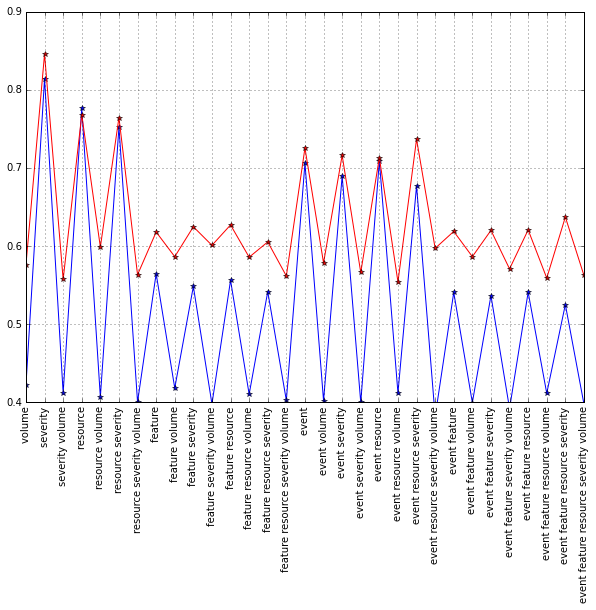

In [36]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*', ylim=(0.4, 0.9))
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*', ylim=(0.4, 0.9))
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

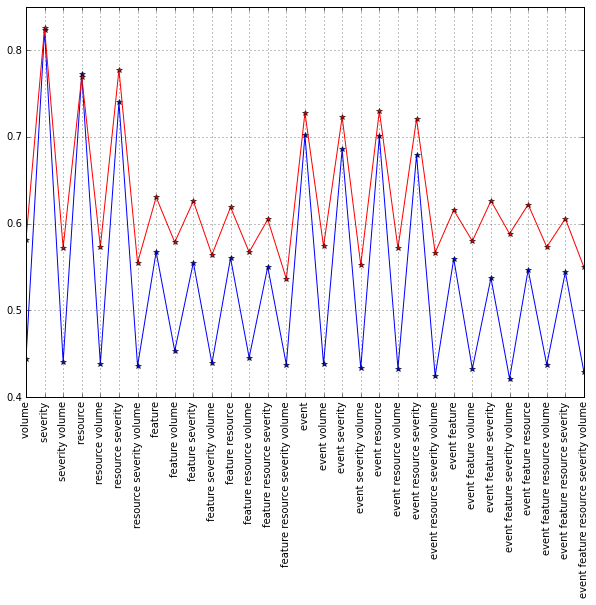

In [43]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

In [43]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.05
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .7
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 500
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([10, 30, 50, 100, 300, 500, 1000, 3000]):
    param['gamma'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round, early_stopping_rounds=3, evals=[(valid_xgmat, 'eval')])
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.065814
[1]	eval-mlogloss:1.034999
[2]	eval-mlogloss:1.007102
[3]	eval-mlogloss:0.981030
[4]	eval-mlogloss:0.957017
[5]	eval-mlogloss:0.934653
[6]	eval-mlogloss:0.914425
[7]	eval-mlogloss:0.895166
[8]	eval-mlogloss:0.877644
[9]	eval-mlogloss:0.860674
[10]	eval-mlogloss:0.844915
[11]	eval-mlogloss:0.830537
[12]	eval-mlogloss:0.816639
[13]	eval-mlogloss:0.803647
[14]	eval-mlogloss:0.791305
[15]	eval-mlogloss:0.780212
[16]	eval-mlogloss:0.769489
[17]	eval-mlogloss:0.759387
[18]	eval-mlogloss:0.750510
[19]	eval-mlogloss:0.741600
[20]	eval-mlogloss:0.733295
[21]	eval-mlogloss:0.725018
[22]	eval-mlogloss:0.717193
[23]	eval-mlogloss:0.709815
[24]	eval-mlogloss:0.703002
[25]	eval-mlogloss:0.696671
[26]	eval-mlogloss:0.690750
[27]	eval-mlogloss:0.685480
[28]	eval-mlogloss:0.680439
[29]	eval-mlogloss:0.675282
[30]	eval-mlogloss:0.670237
[31]	eval-mlogloss:0.665556
[32]	eval-mlogloss:0.660869
[33]	eval-mlogloss:0.657106


0
1

[214]	eval-mlogloss:0.558529
[215]	eval-mlogloss:0.558543
Stopping. Best iteration:
[212]	eval-mlogloss:0.558506

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.066065
[1]	eval-mlogloss:1.036940
[2]	eval-mlogloss:1.009210
[3]	eval-mlogloss:0.984066
[4]	eval-mlogloss:0.960719
[5]	eval-mlogloss:0.938773
[6]	eval-mlogloss:0.918785
[7]	eval-mlogloss:0.900503
[8]	eval-mlogloss:0.883107
[9]	eval-mlogloss:0.866761
[10]	eval-mlogloss:0.851606
[11]	eval-mlogloss:0.837293
[12]	eval-mlogloss:0.824056
[13]	eval-mlogloss:0.811675
[14]	eval-mlogloss:0.800040
[15]	eval-mlogloss:0.789230
[16]	eval-mlogloss:0.779370
[17]	eval-mlogloss:0.769928
[18]	eval-mlogloss:0.760526
[19]	eval-mlogloss:0.752212
[20]	eval-mlogloss:0.744518
[21]	eval-mlogloss:0.736906
[22]	eval-mlogloss:0.729663
[23]	eval-mlogloss:0.722615
[24]	eval-mlogloss:0.716157
[25]	eval-mlogloss:0.710114
[26]	eval-mlogloss:0.704646
[27]	eval-mlogloss:0.699283
[28]	eval-mlogloss:0.693936
[29]	eval-mlogloss:0.68907


2

[195]	eval-mlogloss:0.578290
[196]	eval-mlogloss:0.578119
Stopping. Best iteration:
[193]	eval-mlogloss:0.578088

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.065323
[1]	eval-mlogloss:1.034906
[2]	eval-mlogloss:1.006882
[3]	eval-mlogloss:0.981100
[4]	eval-mlogloss:0.956669
[5]	eval-mlogloss:0.934163
[6]	eval-mlogloss:0.913780
[7]	eval-mlogloss:0.894692
[8]	eval-mlogloss:0.877179
[9]	eval-mlogloss:0.860661
[10]	eval-mlogloss:0.844975
[11]	eval-mlogloss:0.830543
[12]	eval-mlogloss:0.816947
[13]	eval-mlogloss:0.804034
[14]	eval-mlogloss:0.791938
[15]	eval-mlogloss:0.781177
[16]	eval-mlogloss:0.770293
[17]	eval-mlogloss:0.760419
[18]	eval-mlogloss:0.751039
[19]	eval-mlogloss:0.741697
[20]	eval-mlogloss:0.733679
[21]	eval-mlogloss:0.725708
[22]	eval-mlogloss:0.718100
[23]	eval-mlogloss:0.710757
[24]	eval-mlogloss:0.703945
[25]	eval-mlogloss:0.697472
[26]	eval-mlogloss:0.691532
[27]	eval-mlogloss:0.686254
[28]	eval-mlogloss:0.680649
[29]	eval-mlogloss:0.67526


3

[175]	eval-mlogloss:0.559275
[176]	eval-mlogloss:0.559286
[177]	eval-mlogloss:0.559279
Stopping. Best iteration:
[174]	eval-mlogloss:0.559225

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.065860
[1]	eval-mlogloss:1.036397
[2]	eval-mlogloss:1.008954
[3]	eval-mlogloss:0.983238
[4]	eval-mlogloss:0.958711
[5]	eval-mlogloss:0.936627
[6]	eval-mlogloss:0.915570
[7]	eval-mlogloss:0.896510
[8]	eval-mlogloss:0.878620
[9]	eval-mlogloss:0.861576
[10]	eval-mlogloss:0.845870
[11]	eval-mlogloss:0.831290
[12]	eval-mlogloss:0.817304
[13]	eval-mlogloss:0.804384
[14]	eval-mlogloss:0.792361
[15]	eval-mlogloss:0.781112
[16]	eval-mlogloss:0.770455
[17]	eval-mlogloss:0.760489
[18]	eval-mlogloss:0.750790
[19]	eval-mlogloss:0.741945
[20]	eval-mlogloss:0.733185
[21]	eval-mlogloss:0.725346
[22]	eval-mlogloss:0.718063
[23]	eval-mlogloss:0.711563
[24]	eval-mlogloss:0.704984
[25]	eval-mlogloss:0.698622
[26]	eval-mlogloss:0.692440
[27]	eval-mlogloss:0.686963
[28]	eval-mlogloss:0.6813


4

[145]	eval-mlogloss:0.563779
Stopping. Best iteration:
[142]	eval-mlogloss:0.563582

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.065452
[1]	eval-mlogloss:1.035196
[2]	eval-mlogloss:1.006702
[3]	eval-mlogloss:0.981082
[4]	eval-mlogloss:0.957024
[5]	eval-mlogloss:0.934777
[6]	eval-mlogloss:0.914054
[7]	eval-mlogloss:0.894984
[8]	eval-mlogloss:0.877188
[9]	eval-mlogloss:0.860754
[10]	eval-mlogloss:0.844947
[11]	eval-mlogloss:0.830337
[12]	eval-mlogloss:0.816445
[13]	eval-mlogloss:0.803662
[14]	eval-mlogloss:0.791717
[15]	eval-mlogloss:0.780379
[16]	eval-mlogloss:0.769457
[17]	eval-mlogloss:0.759382
[18]	eval-mlogloss:0.750282
[19]	eval-mlogloss:0.741383
[20]	eval-mlogloss:0.733348
[21]	eval-mlogloss:0.724973
[22]	eval-mlogloss:0.717328
[23]	eval-mlogloss:0.710120
[24]	eval-mlogloss:0.703180
[25]	eval-mlogloss:0.696728
[26]	eval-mlogloss:0.690615
[27]	eval-mlogloss:0.684726
[28]	eval-mlogloss:0.679177
[29]	eval-mlogloss:0.673870
[30]	eval-mlogloss:0.668913


5

[195]	eval-mlogloss:0.551683
[196]	eval-mlogloss:0.551608
Stopping. Best iteration:
[193]	eval-mlogloss:0.551572

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.065611
[1]	eval-mlogloss:1.035104
[2]	eval-mlogloss:1.007248
[3]	eval-mlogloss:0.981533
[4]	eval-mlogloss:0.957755
[5]	eval-mlogloss:0.935580
[6]	eval-mlogloss:0.914729
[7]	eval-mlogloss:0.895753
[8]	eval-mlogloss:0.878157
[9]	eval-mlogloss:0.861925
[10]	eval-mlogloss:0.846322
[11]	eval-mlogloss:0.831913
[12]	eval-mlogloss:0.817854
[13]	eval-mlogloss:0.804947
[14]	eval-mlogloss:0.793292
[15]	eval-mlogloss:0.781621
[16]	eval-mlogloss:0.771046
[17]	eval-mlogloss:0.761184
[18]	eval-mlogloss:0.751682
[19]	eval-mlogloss:0.742255
[20]	eval-mlogloss:0.733684
[21]	eval-mlogloss:0.725900
[22]	eval-mlogloss:0.717990
[23]	eval-mlogloss:0.710966
[24]	eval-mlogloss:0.704202
[25]	eval-mlogloss:0.697270
[26]	eval-mlogloss:0.691244
[27]	eval-mlogloss:0.685687
[28]	eval-mlogloss:0.680239
[29]	eval-mlogloss:0.67509


6

[150]	eval-mlogloss:0.558694
[151]	eval-mlogloss:0.558657
Stopping. Best iteration:
[148]	eval-mlogloss:0.558648

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.065546
[1]	eval-mlogloss:1.035163
[2]	eval-mlogloss:1.007216
[3]	eval-mlogloss:0.981100
[4]	eval-mlogloss:0.957241
[5]	eval-mlogloss:0.934770
[6]	eval-mlogloss:0.914183
[7]	eval-mlogloss:0.895309
[8]	eval-mlogloss:0.877909
[9]	eval-mlogloss:0.861034
[10]	eval-mlogloss:0.845321
[11]	eval-mlogloss:0.830594
[12]	eval-mlogloss:0.817210
[13]	eval-mlogloss:0.804459
[14]	eval-mlogloss:0.792662
[15]	eval-mlogloss:0.781552
[16]	eval-mlogloss:0.770829
[17]	eval-mlogloss:0.760940
[18]	eval-mlogloss:0.751162
[19]	eval-mlogloss:0.742295
[20]	eval-mlogloss:0.733836
[21]	eval-mlogloss:0.726157
[22]	eval-mlogloss:0.718475
[23]	eval-mlogloss:0.711252
[24]	eval-mlogloss:0.704378
[25]	eval-mlogloss:0.698228
[26]	eval-mlogloss:0.692298
[27]	eval-mlogloss:0.686720
[28]	eval-mlogloss:0.680928
[29]	eval-mlogloss:0.67588


7

Stopping. Best iteration:
[181]	eval-mlogloss:0.564888

Will train until eval error hasn't decreased in 3 rounds.
[0]	eval-mlogloss:1.065393
[1]	eval-mlogloss:1.035239
[2]	eval-mlogloss:1.006645
[3]	eval-mlogloss:0.980524
[4]	eval-mlogloss:0.956395
[5]	eval-mlogloss:0.934143
[6]	eval-mlogloss:0.913491
[7]	eval-mlogloss:0.893979
[8]	eval-mlogloss:0.875820
[9]	eval-mlogloss:0.858744
[10]	eval-mlogloss:0.842878
[11]	eval-mlogloss:0.828624
[12]	eval-mlogloss:0.814636
[13]	eval-mlogloss:0.801829
[14]	eval-mlogloss:0.789758
[15]	eval-mlogloss:0.778268
[16]	eval-mlogloss:0.767280
[17]	eval-mlogloss:0.757099
[18]	eval-mlogloss:0.747220
[19]	eval-mlogloss:0.738494
[20]	eval-mlogloss:0.730128
[21]	eval-mlogloss:0.722425
[22]	eval-mlogloss:0.715027
[23]	eval-mlogloss:0.708168
[24]	eval-mlogloss:0.701176
[25]	eval-mlogloss:0.694546
[26]	eval-mlogloss:0.688351
[27]	eval-mlogloss:0.682779
[28]	eval-mlogloss:0.677370
[29]	eval-mlogloss:0.672501
[30]	eval-mlogloss:0.667615
[31]	eval-mlogloss:0.663313


Stopping. Best iteration:
[181]	eval-mlogloss:0.555761



In [42]:
xgb.train?

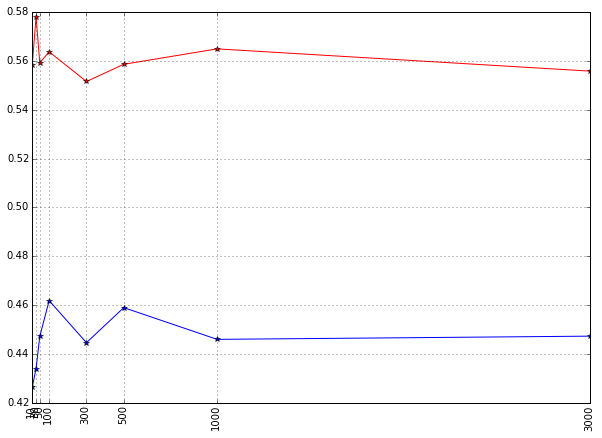

In [44]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(res.index, res.index)
plt.grid()
plt.show()

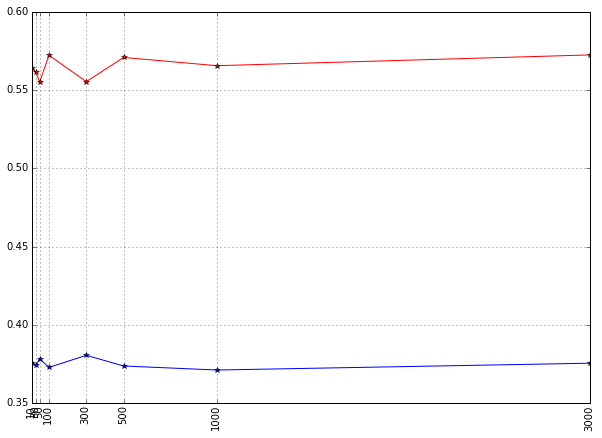

In [131]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(res.index, res.index)
plt.grid()
plt.show()

In [112]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 25, 30, 35]):
    param['max_depth'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [122]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 100, 1000]):
    param['min_child_weight'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6


In [126]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 100, 1000]):
    param['max_delta_step'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0 123174044
1 123174047
2 123174050
3 123174053
4 123174056
5 123174059
6 123174102


In [ ]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .2, .3, .4, .5, .6, .7, .8, .9]):
    param['colsample_bytree'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

In [100]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 30, 50, 70, 90, 100]):
    param['lambda'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0 123171229
1 123171232
2 123171234
3 123171237
4 123171239
5 123171242
6 123171245
7 123171247
8 123171250
9 123171253


In [ ]:
# setup parameters for xgboost
param = {}
# use logistic regression loss
param['objective'] = 'multi:softprob'
param['bst:eta'] = 0.12
param['bst:max_depth'] = 6
param['eval_metric'] = 'mlogloss'
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3
param['subsample'] = .5
insample_evaluates = []
outsample_evaluates = []
com_cats = []
num_round = 200
plst = list(param.items())
pattern = r'.*:(?P<evaluate>0.\d*)'
for rid, com_range in enumerate([.1, .5, 1, 5, 10, 30, 50, 70, 90, 100]):
    param['alpha'] = com_range
    random_state = int(dt.datetime.today().strftime("%m%d%H%M%S"))
    print(rid, random_state)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, 3:].values,
        train.loc[:, 'fault_severity'].values,
        test_size=.333,
        random_state=random_state)
    train_xgmat = xgb.DMatrix(train_x, label=train_y)
    valid_xgmat = xgb.DMatrix(valid_x, label=valid_y)
    bst = xgb.train(plst, train_xgmat, num_round)
    evaluate = float(re.search(pattern, str(bst.eval(train_xgmat))).groupdict()['evaluate'])
    insample_evaluates.append(evaluate)
    evaluate = float(re.search(pattern, str(bst.eval(valid_xgmat))).groupdict()['evaluate'])
    outsample_evaluates.append(evaluate)
    com_cats.append(com_range)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

In [44]:
xgmat = xgb.DMatrix(train.iloc[:, 3:], label=train.loc[:, 'fault_severity'])
bst = xgb.train(plst, xgmat, 200)

In [45]:
testmat = xgb.DMatrix(test.iloc[:, 2:])

In [46]:
prob = bst.predict(testmat)

In [47]:
prob

array([[  9.58419323e-01,   4.14050445e-02,   1.75691166e-04],
       [  2.97163814e-01,   8.95997509e-02,   6.13236427e-01],
       [  9.77949262e-01,   2.18781326e-02,   1.72624452e-04],
       ..., 
       [  3.06886226e-01,   5.68169832e-01,   1.24943919e-01],
       [  9.46187854e-01,   5.35393730e-02,   2.72758276e-04],
       [  8.94896150e-01,   1.04191989e-01,   9.11840412e-04]], dtype=float32)

In [48]:
xgbc_prob = pd.DataFrame({
    'id': sample.loc[:, 'id'].values, 
    'predict_0': prob[:, 0],
    'predict_1': prob[:, 1],
    'predict_2': prob[:, 2]})

In [49]:
xgbc_prob.to_csv('xgbc.csv', index=False)

In [51]:
xgbc_prob.head()

,id,predict_0,predict_1,predict_2
0,11066,0.958419,0.041405,0.000176
1,18000,0.297164,0.089600,0.613236
2,16964,0.977949,0.021878,0.000173
3,4795,0.707602,0.280961,0.011436
4,3392,0.165933,0.812566,0.021501
